In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import numpy as np

In [2]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 14.4,
#     'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [3]:
%load_ext Cython

In [4]:
%%cython -a

import numpy as np
from PIL import Image
import os
import pandas as pd
from tqdm import tqdm
import Ising

cimport cython
cimport numpy as np
from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX



cdef class cy_Spin:
    cdef np.int64_t value
    
    def __init__(self,np.int64_t value):
        self.value = value
        return
    
    def flip(self):
        self.value *= -1
        return 0
    
@cython.boundscheck(False)
cdef class cy_Ising:
    cdef np.int64_t D, N_total_spins, N_free_spins, magnetization
    cdef np.int64_t[:] N_spins, free_index_list
    cdef str boundary
    cdef cy_Spin[:] spins
    
    
    def __init__(self,int dimension,np.int64_t[:] Num_spins,str fix_boundary='periodic', str start='ferro'):
        '''
        D dimensional lattice of spins
        N_spins controls the number of spin on each axis
        boundary:
            'periodic': the system self replicates
            'free': nothing beyond the surface of the system
            1 or -1: the system is surrounded by all aligned spins
        Spins are randomly initialized
        '''
        
        self.D = dimension
        if len(Num_spins) == self.D:
            self.N_spins = np.array(Num_spins,dtype=int)
        else:
            raise TypeError('N_spins must be integer or D long list of integers')
            
        self.N_total_spins = 1
        cdef np.int64_t n_s
        for n_s in self.N_spins:
            self.N_total_spins *= (n_s + 2)
            
        self.boundary = fix_boundary
        
        cdef np.int64_t j
        cdef list ss = []
        cdef np.int64_t ferro_coeff = 0
        if start == 'ferro':
            ferro_coeff = np.random.choice([-1,1])
        for j in range(self.N_total_spins):
            if start == 'ferro':
                ss.append(cy_Spin(ferro_coeff))
            else:
                ss.append(cy_Spin(np.random.choice([-1,1])))
        self.spins = np.array(ss)
        
        self.free_index_list = self.make_surface()
        self.N_free_spins = len(self.free_index_list)
        if self.N_free_spins != np.product(self.N_spins):
            raise ValueError('Surface not correctly computed')
        
        self.magnetization = 0
        self.compute_magnetization()
        
    cpdef compute_magnetization(self):
        cdef np.int64_t j
        cdef np.int64_t s_sum = 0
        for j in self.free_index_list:
            s_sum += self.spins[j].value
        self.magnetization = s_sum
        
    cpdef average_magnetization(self):
        return (1.*self.magnetization)/self.N_free_spins
    
    cpdef domain_wall_density(self): # computes the fraction of spins not completely sorrounded by spins with the same value
        cdef np.int64_t ndw = 0
        cdef np.int64_t j,w,i
        cdef np.int64_t s
        cdef np.int64_t[:] indexs
        
        for j in self.free_index_list:
            s = self.spins[j].value
            indexs = self.get_indexs(j)
            dw = False
            for i in range(self.D):
                indexs[i] += 1
                w = self.get_index(indexs)
                if s != self.spins[w].value:
                    dw = True
                    break
                indexs[i] -= 2
                w = self.get_index(indexs)
                if s != self.spins[w].value:
                    dw = True
                    break
                indexs[i] += 1
            if dw:
                ndw += 1
        
        return (1.*ndw)/self.N_free_spins
    
    
    cpdef get_index(self,np.int64_t[:] indexs):
        if len(indexs) != self.D:
            raise IndexError('Wrong number of indexs')
   
        cdef np.int64_t j = 0
        cdef np.int64_t coeff = 1
        for i in range(self.D):
                j += indexs[i]*coeff
                coeff *= (self.N_spins[i] + 2)
        return j
    
    cpdef get_indexs(self,np.int64_t index):
        cdef np.int64_t[:] indexs = np.zeros(self.D,dtype=int)
        cdef np.int64_t r = index
        cdef np.int64_t i
        cdef np.int64_t coeff = self.N_total_spins
        for i in range(1,self.D + 1):
            coeff /= (self.N_spins[self.D - i] + 2)
            indexs[self.D - i] = r // coeff
            r -= indexs[self.D - i]*coeff

        return indexs
    
    cpdef is_surface(self,np.int64_t j):
        cdef np.int64_t[:] indexs = self.get_indexs(j)
        cdef np.int64_t i
        if 0 in indexs:
            return True
        for i in range(self.D):
            if indexs[i] == self.N_spins[i] + 1:
                return True
    
    cpdef make_surface(self):
        cdef np.int64_t j, i, k, q
        cdef np.int64_t[:] indexs
        cdef list free_in_list = []
        for j in range(self.N_total_spins):
            if self.is_surface(j):
                if self.boundary == 'free':
                    self.spins[j].value = 0
                elif self.boundary == 'periodic':
                    indexs = self.get_indexs(j)
                    for i,k in enumerate(indexs):
                        if k == 0:
                            indexs[i] = self.N_spins[i]
                        elif k == self.N_spins[i] + 1:
                            indexs[i] = 1
                    q = self.get_index(indexs)
                    self.spins[j] = self.spins[q]
                    
                else:
                    self.spins[j].value = int(self.boundary)
            else:
                free_in_list.append(j)
        return np.array(free_in_list)
                    
        
    def view(self):
        cdef cy_Spin s
        if self.D == 2:
            return Image.fromarray((np.uint8([s.value for s in self.spins]).reshape(np.array(self.N_spins) + 2) + 1)*127)
    
    
    def save(self,str folder,overwrite=False):
        folder = folder.rstrip('/')
        if os.path.exists(folder):
            if not overwrite:
                print('Cannot save: file exists')
                return False
        else:
            os.mkdir(folder)
        
        file = open(folder+'/settings.txt','w')
        cdef str s = ''
        cdef np.int64_t N
        for N in self.N_spins:
            s += str(N) + ' '
        s += '\n'
        s += str(self.boundary) + '\n'
        file.write(s)
        file.close()
        
        np.save(folder+'/spins.npy',np.array([s.value for s in self.spins]))
        return True
    
    cpdef copy(self):
        cdef cy_Ising I = cy_Ising(dimension=self.D,Num_spins=self.N_spins,fix_boundary=self.boundary)
        cdef np.int64_t j
        for j in self.free_index_list:
            I.spins[j].value = self.spins[j].value
            
        return I
    
#     def to_Ising(self):
#         I = Ising(dimension=self.D,N_spins=self.N_spins,boundary=self.boundary)
#         cdef np.int64_t j
#         for j in self.free_index_list:
#             I.spins[j].value = self.spins[j].value
            
#         return I
    
    
def load_cy_Ising(folder):
    folder = folder.rstrip('/')
    file = open(folder+'/settings.txt','r')
    s = file.readline().rstrip('\n').rstrip(' ')
    N_spins = np.array(s.split(' '),dtype=int)
    boundary = file.readline().rstrip('\n')
    
    I = cy_Ising(dimension=len(N_spins),Num_spins=N_spins,fix_boundary=boundary)
    
    spins = np.load(folder+'/spins.npy')
    for j in I.free_index_list:
        I.spins[j].value = spins[j]
        
    return I


cpdef to_cy(I):
#     print('converting to cy_I')
    cdef cy_Ising cy_I = cy_Ising(dimension=I.D,Num_spins = I.N_spins, fix_boundary=I.boundary)
    cdef np.int64_t j
    for j in cy_I.free_index_list:
        cy_I.spins[j].value = I.spins[j].value
    return cy_I

@cython.boundscheck(False)
def cy_evolve(obj, np.int64_t t_max, float k,float h=0. ,str criterion='random',
              np.int64_t check_time=1,str logfile='',np.int64_t log_time=100,
              np.int64_t max_updates=0, np.int64_t jump=1):
    
    if log_time % check_time != 0:
        raise ValueError('log_time must be a multiple of check_time')
    
    cdef cy_Ising I = obj
    cdef np.int64_t[:] permutated_list
    
    df = pd.DataFrame(data=[],columns=['step','tot_E','a','m','acceptance','wall_density'])
    cdef np.int64_t[:] acceptance_history = np.zeros(log_time//check_time,dtype=int) # 0: rejected, 1: accepted
    
    if criterion == 'cycle' and jump > 1 and I.N_free_spins % jump == 0:
        print('Warning: not all the spins will be flipped, expect unphysical results')
    
    if criterion == 'permutate':
        permutated_list = np.random.permutation(I.free_index_list)
    
    cdef float total_energy = 0
    cdef np.int64_t total_alignment = 0
    cdef list j_list = []
    cdef np.int64_t[:] indexs
    cdef np.int64_t j = 0
    cdef np.int64_t i = 0
    cdef np.int64_t w = 1
    cdef np.int64_t q = 0
    cdef float delta_E = 0
    cdef np.int64_t delta_a = 0
    cdef np.int64_t delta_m = 0
    cdef np.int64_t spin_sum = 0
    acceptance_history[0] = 1
    accepted = False
    
    if max_updates == 0:
        for j in I.free_index_list:
            indexs = I.get_indexs(j)
            spin_sum = 0
            for i in range(I.D):
                indexs[i] += 1
                spin_sum += I.spins[I.get_index(indexs)].value
                indexs[i] -= 2
                spin_sum += I.spins[I.get_index(indexs)].value
                indexs[i] += 1
            total_energy += -I.spins[j].value*(h + k*spin_sum)
            total_alignment += I.spins[j].value*spin_sum
        I.compute_magnetization()
        
    
#     cdef list selected_js = []
    
    cdef np.int64_t t
    for t in tqdm(range(t_max + 1)):
#     for t in range(t_max + 1): #save also the last point
        if t % check_time == 0 and t != 0:
            #check if the move is good
            accepted = False
            if delta_E <= 0:
                accepted = True
            elif rand() < RAND_MAX*exp(-delta_E):
                accepted = True
            
            if accepted:
                I.magnetization += delta_m
                total_energy += delta_E
                total_alignment += delta_a
                acceptance_history[w] = 1
            else:
                #revert to original situation
                for q in j_list:
#                     I.spins[q].value *= -1
                    I.spins[q].flip()
                acceptance_history[w] = 0
            
            j_list = []
            delta_E = 0
            delta_m = 0
            delta_a = 0
            w += 1
        
        if max_updates > 0:
            if t % (check_time*max_updates) == 0:
                total_energy = 0
                total_alignment = 0
                for j in I.free_index_list:
                    indexs = I.get_indexs(j)
                    spin_sum = 0
                    for i in range(I.D):
                        indexs[i] += 1
                        spin_sum += I.spins[I.get_index(indexs)].value
                        indexs[i] -= 2
                        spin_sum += I.spins[I.get_index(indexs)].value
                        indexs[i] += 1
                    total_energy += -I.spins[j].value*(h + k*spin_sum)
                    total_alignment += I.spins[j].value*spin_sum
                I.compute_magnetization()
            
        if t % log_time == 0:
            w = 0
            df.loc[len(df)] = [t, total_energy, total_alignment/(I.N_free_spins*2*I.D),
                   I.average_magnetization(),np.mean(acceptance_history),I.domain_wall_density()]
            
        
        
        if criterion == 'cycle':
            j = I.free_index_list[(t*jump) % I.N_free_spins]
        elif criterion == 'random':
            j = I.free_index_list[np.int64(rand()*I.N_free_spins/RAND_MAX)]
        elif criterion == 'permutate':
            j = permutated_list[t % I.N_free_spins]
#         selected_js.append(j)
            
        j_list.append(j)
        I.spins[j].flip()
#         I.spins[j].value *= -1
        delta_m += 2*I.spins[j].value
        indexs = I.get_indexs(j)
        spin_sum = 0
        for i in range(I.D):
            indexs[i] += 1
            spin_sum += I.spins[I.get_index(indexs)].value
            indexs[i] -= 2
            spin_sum += I.spins[I.get_index(indexs)].value
            indexs[i] += 1
        delta_E += -2*I.spins[j].value*(h + 2*k*spin_sum)
        delta_a += 4*I.spins[j].value*spin_sum
        
    if logfile != '':
        df.to_csv(logfile,index=False)
        
    return I, df #, np.array(selected_js)
    
    

####### NOT WORTH IT
    
# @cython.boundscheck(False)
# def cy_evolve_fast(obj, np.int64_t t_max, float k,float h=0. ,str criterion='random',
#                    str logfile='',np.int64_t log_time=100, np.int64_t jump=1):
      
#     cdef cy_Ising I = obj
    
#     df = pd.DataFrame(data=[],columns=['step','tot_E','spec_E','m','acceptance','wall_density'])
#     cdef np.int64_t[:] acceptance_history = np.zeros(log_time,dtype=int) # 0: rejected, 1: accepted
    
#     if criterion == 'cycle' and jump > 1 and np.gcd(I.N_free_spins,jump) != 1:
#         print('Warning: not all the spins will be flipped, expect unphysical results')
    
#     cdef float total_energy = 0
#     cdef np.int64_t[:] indexs
#     cdef np.int64_t j = 0
#     cdef np.int64_t i = 0
#     cdef np.int64_t w = 0
#     cdef float delta_E = 0
#     cdef np.int64_t delta_m = 0
#     cdef np.int64_t spin_sum = 0
#     accepted = False
    
#     # assumes I has a magnetizaton already computed
#     for j in I.free_index_list:
#         indexs = I.get_indexs(j)
#         spin_sum = 0
#         for i in range(I.D):
#             indexs[i] += 1
#             spin_sum += I.spins[I.get_index(indexs)].value
#             indexs[i] -= 2
#             spin_sum += I.spins[I.get_index(indexs)].value
#             indexs[i] += 1
#         total_energy += -I.spins[j].value*k*spin_sum
#     total_energy -= h*I.magnetization
    
    
#     cdef np.int64_t t
#     for t in range(t_max + 1): #in order to collect also the last point
#         if t % log_time == 0:
#             w = 0
#             df.loc[len(df)] = [t, total_energy, total_energy/(k*I.N_free_spins*2*I.D),
#                    I.average_magnetization(),np.mean(acceptance_history),I.domain_wall_density()]
        
#         if criterion == 'cycle':
#             j = I.free_index_list[(t*jump) % I.N_free_spins]
#         elif criterion == 'random':
#             j = I.free_index_list[np.int64(rand()*I.N_free_spins/RAND_MAX)]
            
# #         I.spins[j].flip()
# #         I.spins[j].value *= -1
#         delta_m = -2*I.spins[j].value
#         indexs = I.get_indexs(j)
#         spin_sum = 0
#         for i in range(I.D):
#             indexs[i] += 1
#             spin_sum += I.spins[I.get_index(indexs)].value
#             indexs[i] -= 2
#             spin_sum += I.spins[I.get_index(indexs)].value
#             indexs[i] += 1
#         delta_E = 2*I.spins[j].value*(h + k*spin_sum)
        
        
#         #check if the move is good
#         accepted = False
#         if delta_E <= 0:
#             accepted = True
#         elif rand() < RAND_MAX*exp(-delta_E):
#             accepted = True

#         if accepted:
#             I.magnetization += delta_m
#             total_energy += delta_E
#             acceptance_history[w] = 1
#             I.spins[j].flip()
#         else:
#             acceptance_history[w] = 0
        
#         w += 1
            
#     if logfile != '':
#         df.to_csv(logfile,index=False)
        
#     return I, df

In [21]:
I = Ising.Ising(2,128)
cy_I = to_cy(I)
I.average_magnetization()

-0.0114

In [88]:
cy_I_fin, df, s_l = cy_evolve(cy_Ising(2,np.array([128,128])),k=16,
                           criterion='random',t_max=1000000,log_time=10000)

In [89]:
for j in I.free_index_list:
    if j not in s_l:
        print(j)

In [26]:
# start_time = time()
# I_fin, df = Ising.evolve(I,k=2,t_max=1000000,check_time=1,log_time=10000,max_updates=10000000)
# end_time = time()
# print(end_time - start_time)

start_time = time()
cy_I_fin, cy_df = cy_evolve(cy_I.copy(),k=2,t_max=10000000,check_time=1,log_time=10000,
                            max_updates=10000000,criterion='cycle',jump=3)
end_time = time()
print(end_time - start_time)

start_time = time()
cy_I_fast_fin, cy_fast_df = cy_evolve_fast(cy_I.copy(),k=2,t_max=10000000,
                                           log_time=10000,criterion='cycle',jump=3)
end_time = time()
print(end_time - start_time)

37.0617413520813
36.691874742507935


<IPython.core.display.Javascript object>


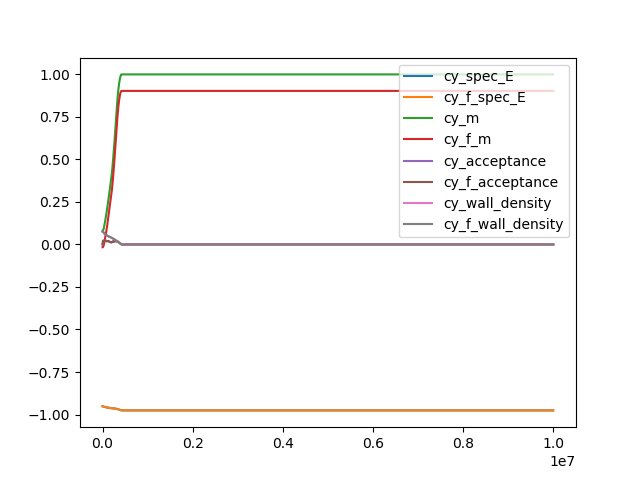

In [27]:
%matplotlib notebook
keys = ['spec_E', 'm', 'acceptance','wall_density']

plt.figure()
for key in keys[:]:
#     plt.plot(df['step'],df[key],label=key)
    plt.plot(cy_df['step'],cy_df[key],label='cy_'+key)
    plt.plot(cy_fast_df['step'],cy_fast_df[key],label='cy_f_'+key)
plt.legend()

In [35]:
# cy_I_fin.compute_magnetization()
cy_I_fin.average_magnetization()

1.0

<IPython.core.display.Javascript object>


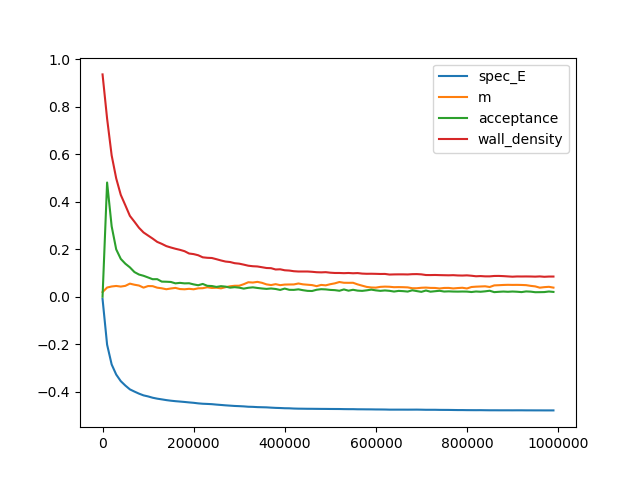

In [62]:
plt.figure()
for key in keys[:]:
    plt.plot(cy_df['step'],cy_df[key],label=key)
plt.legend()

In [5]:
iterations = 5
t_max = np.int64(1e07)
max_updates = np.int64(1e08)
cy_I_list = []
cy_df_list = []
for i in range(iterations):
    start_time = time()
    cy_I_list.append(cy_Ising(2,np.array([128,128])))
    cy_I, df = cy_evolve(cy_I_list[-1],k=0.2,t_max=t_max,check_time=1,
                         criterion='permutate', jump=37,log_time=10000,max_updates=max_updates)
    cy_df_list.append(df)
    end_time = time()
    print(end_time - start_time)

52.27852773666382
51.15397000312805
53.85733222961426
51.942442417144775
52.39884805679321


In [10]:
for cy_I in cy_I_list:
    fig = cy_I.view()
    fig.show()

<IPython.core.display.Javascript object>


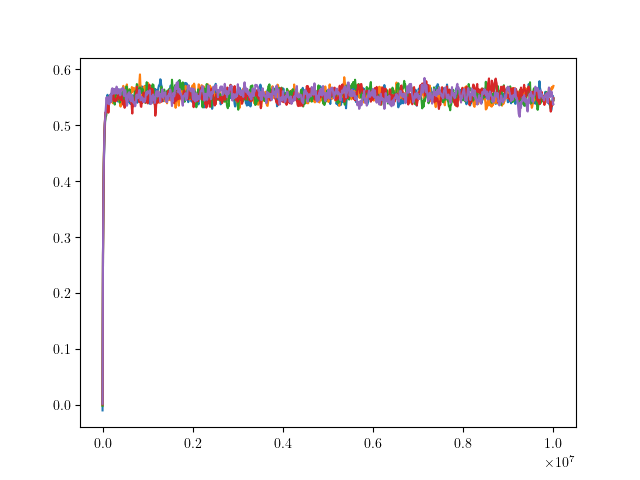

In [9]:
%matplotlib notebook
key = 'a'
plt.figure()
for i,df in enumerate(cy_df_list):
    plt.plot(df['step'],df[key],label=key+'_%d' %i)
plt.legend()

    

<IPython.core.display.Javascript object>


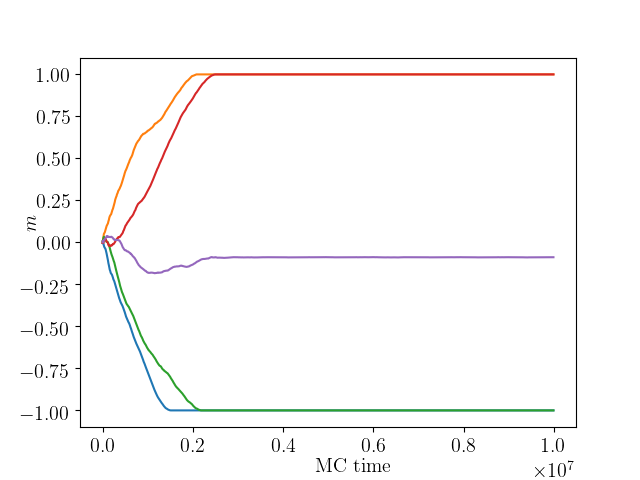

In [68]:
%matplotlib notebook
key = 'm'

fig,ax = plt.subplots()
for df in cy_df_list:
    ax.plot(df['step'],df[key])

ax.set_xlabel('MC time')
ax.set_ylabel('$m$')
ax.xaxis.set_label_coords(0.55,-0.08)
ax.yaxis.set_label_coords(-0.08,0.55)

fig.savefig('report/img/m_k16_permutate_c1.pgf')

<IPython.core.display.Javascript object>


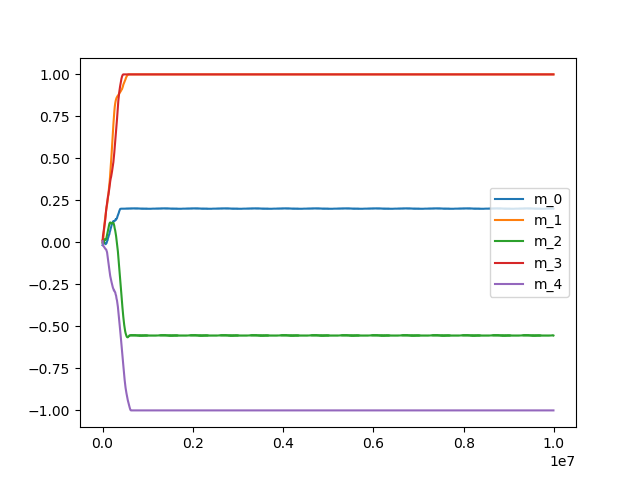

In [63]:
key = 'm'
plt.figure()
for i,df in enumerate(cy_df_list):
    plt.plot(df['step'],df[key],label=key+'_%d' %i)
plt.legend()
    

<IPython.core.display.Javascript object>


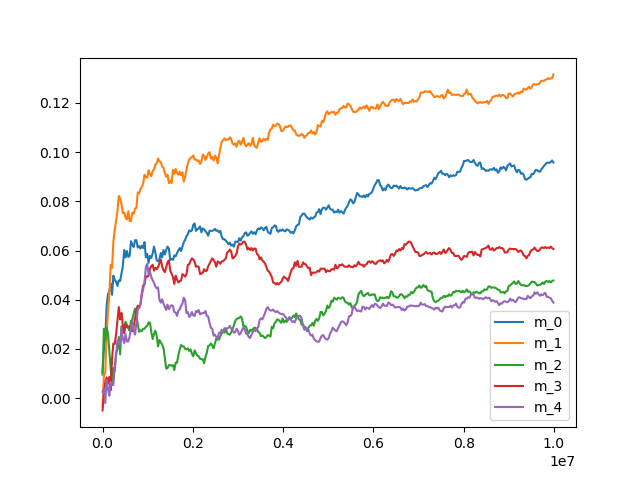

In [87]:
keys = ['m', 'acceptance', 'wall_density']
plt.figure()
for key in keys[:1]:
    for i,df in enumerate(cy_df_list):
        plt.plot(df['step'],df[key],label=key+'_%d' %i)
plt.legend()

In [71]:
cy_I_list[4].view().save('report/img/k16_permutate_fin_c1.png')

In [69]:
cy_I_list[4].average_magnetization()

-0.0880126953125

# Block averaging

In [5]:
def block_average(data,n,coarse_sampling=1,save_stds=False):
    coarse_data = 0
    if coarse_sampling == 1:
        coarse_data = data
    else:
        coarse_data = pd.DataFrame(data=[],columns=data.keys())
        for i in np.arange(0,len(data))[::coarse_sampling]:
            coarse_data.loc[len(coarse_data)] = data.values[i]
    if n == 1:
        return coarse_data
    
    new_keys = []
    if save_stds:
        for k in coarse_data.keys():
            new_keys.append(k)
            new_keys.append(k+'_std')
    else:
        new_keys = coarse_data.keys()
    new_data = pd.DataFrame(data=[],columns=new_keys)
    
    for i in range(int(len(coarse_data)/n)):
        v = []
        for k in coarse_data.keys():
            v.append(np.mean(coarse_data[k][n*i:n*(i + 1)]))
            if save_stds:
                v.append(np.std(coarse_data[k][n*i:n*(i + 1)],ddof=1))
        new_data.loc[len(new_data)] = v
    
    return new_data

100%|██████████| 81920001/81920001 [03:31<00:00, 387994.61it/s]

211.18216228485107


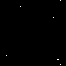

In [92]:
Nx = 64
t_max = int(20000*Nx**2)
log_time = int(50*Nx**2)

start_time = time()
I_fin, raw_data = cy_evolve(cy_Ising(2,np.array([Nx,Nx]),start='ferro'),
                            k=0.4,t_max=t_max, criterion='permutate',
                            log_time=log_time)
print(time() - start_time)
I_fin.view()

 40%|████      | 4/10 [00:00<00:01,  5.98it/s]


<IPython.core.display.Javascript object>


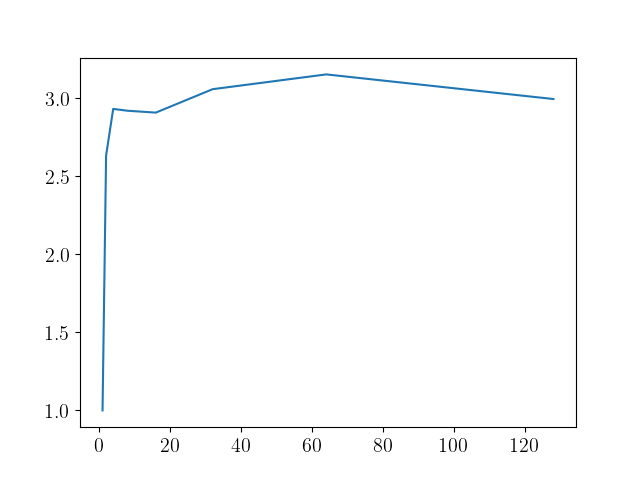

array([400, 200, 100,  50,  25,  12,   6,   3])

In [85]:
minstep = 0
coarse_sampling = 1
coarsed_data = block_average(raw_data,1,coarse_sampling)
# ns = np.arange(4,100,2)
ns = 2**np.arange(10)
key = 'm'
sigs = []
n_data = []
for n in tqdm(ns):
    data = block_average(coarsed_data,n)
    min_index = 0
    for i,s in enumerate(data['step']):
        if s > minstep:
            min_index = i
            #print(min_index)
            break
    if len(data['step'][min_index:]) <= 1:
        break
    n_data.append(len(data['step'][min_index:]))
    sigs.append(np.std(data[key][min_index:],ddof=1)/np.sqrt(len(data['step'][min_index:])))
n_data = np.array(n_data)
sigs = np.array(sigs)

plt.figure()
plt.plot(ns[:len(sigs)],sigs/sigs[0])
# plt.plot(ns,n_data/n_data[0])
n_data

<IPython.core.display.Javascript object>


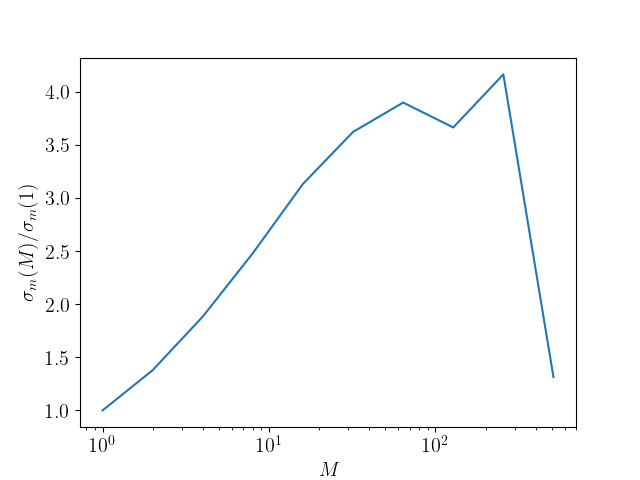

In [68]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.semilogx(ns[:len(sigs)],sigs/sigs[0])
ax.set_xlabel('$M$')
ax.set_ylabel(r'$\sigma_m(M)/\sigma_m(1)$')
# fig.savefig('report/img/block_averaging.pgf')

<IPython.core.display.Javascript object>


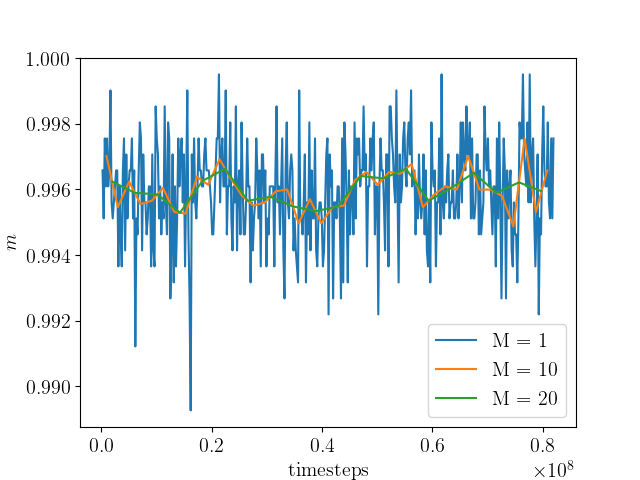

In [94]:
key = 'm'

ns = [1,10,20]
plt.figure()
for n in ns:
    data = block_average(raw_data,n)
    xs = np.array([s for s in data['step'] if s > minstep])
    ys = -np.array([k for i,k in enumerate(data[key]) if data['step'][i] > minstep])
    plt.plot(xs,ys,label='M = %d' %n)
#     popt,pcov = linfit(data,minstep,key,maxstep=maxstep,plot=False)
#     print(popt,pcov)
    
plt.xlabel('timesteps')
plt.ylabel('$m$')
plt.legend()
plt.savefig('report/img/equilibration_k0.4_ferro.pgf')

# Simulations

In [6]:
def index_keys(keys,iks=['k','time']):
    for k in keys:
        iks.append(k)
        iks.append(k+'_std')
    return np.array(iks)

In [7]:
D = 2
N = 16
k_l = 0.75*0.17
k_u = 1.25*0.44
ks = np.linspace(k_l,k_u,1000)[::10]
# ks = np.linspace(0.5,8,1000)[::10]
ofile = 'results.csv'
average_keys = ['m', 'a', 'wall_density']
simulate = True

big_folder = 'sim'
sub_folder = big_folder+'/D%d_N%d_para' %(D,N)
if not os.path.exists(sub_folder):
    os.mkdir(sub_folder)
    
if not os.path.exists(sub_folder+'/'+ofile):
    df = pd.DataFrame(data=[],columns=index_keys(average_keys))
else:
    df = pd.read_csv(sub_folder+'/'+ofile)
    
Ns = [N]*D
t_max = int(20000*N**D)
log_time = int(50*N**D)
M = 20 #block averaging parameter
min_index = 2
    
for i,k in enumerate(ks):
    start_time = time()
    if simulate:
        I_fin, raw_data = cy_evolve(cy_Ising(D,np.array(Ns),start='para'),
                                    k=k,t_max=t_max, criterion='permutate',
                                    log_time=log_time,logfile=sub_folder+'/evolution_k%.4f.csv' %k)
#         I_fin.view().save(sub_folder+'/I_fin_k%.4f.png' %k)
    else:
        raw_data=pd.read_csv(sub_folder+'/evolution_k%.4f.csv' %k)
    
    b_data = block_average(raw_data,M)
    avgs = []
    for key in average_keys:
        avgs.append(np.mean(b_data[key][min_index:]))
        avgs.append(np.std(b_data[key][min_index:],ddof=1)/np.sqrt(len(b_data['step'][min_index:])))
        
    t = time() - start_time
    df.loc[len(df)] = [k,t] + avgs
    print(i,k,t)
    
df.to_csv(sub_folder+'/'+ofile, index=False)

  1%|▏         | 73232/5120001 [00:00<00:14, 360253.78it/s]

0 0.1275 12.09835696220398


  2%|▏         | 77817/5120001 [00:00<00:13, 383408.58it/s]

1 0.13172922922922922 12.206623315811157


  1%|          | 38237/5120001 [00:00<00:13, 382360.34it/s]

2 0.13595845845845847 12.043840408325195


  1%|▏         | 76608/5120001 [00:00<00:13, 377896.35it/s]

3 0.1401876876876877 12.154508113861084


  1%|          | 33433/5120001 [00:00<00:15, 334326.33it/s]

4 0.1444169169169169 12.047543048858643


  1%|▏         | 71883/5120001 [00:00<00:14, 348603.81it/s]

5 0.14864614614614616 12.461781740188599


  1%|          | 37119/5120001 [00:00<00:13, 371185.93it/s]

6 0.15287537537537538 12.41732120513916


  2%|▏         | 76801/5120001 [00:00<00:13, 379076.73it/s]

7 0.15710460460460463 12.302208662033081


  1%|▏         | 74130/5120001 [00:00<00:13, 370210.77it/s]

8 0.16133383383383385 12.535561800003052


 21%|██        | 1074564/5120001 [00:02<00:09, 409211.68it/s]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


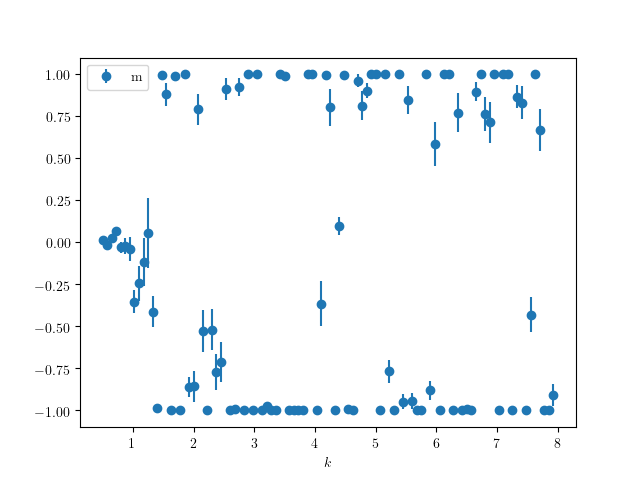

Text(0.5, 0, '$k$')

In [42]:
%matplotlib notebook
keys = ['m','a','wall_density'][:1]

plt.figure()
for key in keys:
    plt.errorbar(df['k'],df[key],yerr=df[key+'_std'],label=key,fmt='o')
plt.legend()
plt.xlabel('$k$')

<IPython.core.display.Javascript object>


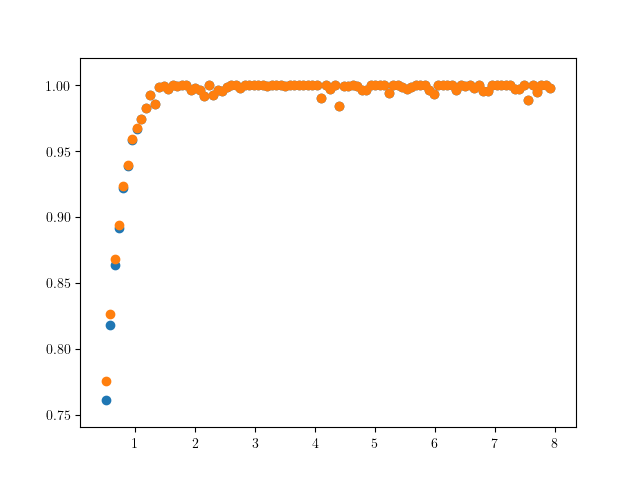

In [43]:
plt.figure()
plt.scatter(df['k'],df['a'])
plt.scatter(df['k'], 1- df['wall_density'])

In [44]:
#load evolution
e_df = pd.read_csv('sim/D1_N256_para_random/evolution_k4.4790.csv')

<IPython.core.display.Javascript object>


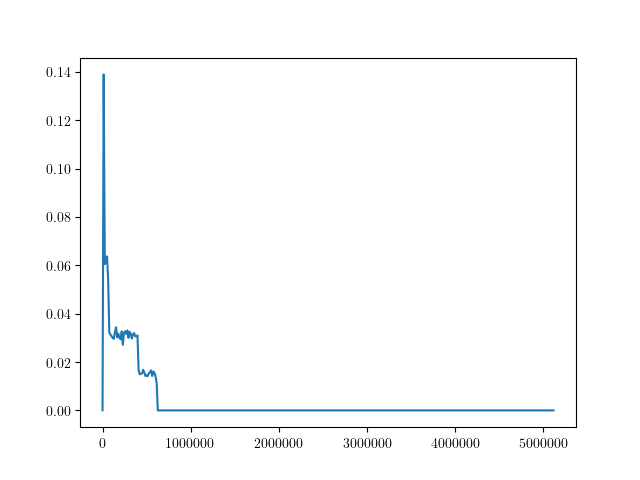

In [45]:
key = 'acceptance'

plt.figure()
plt.plot(e_df['step'],e_df[key])